# Correlations of xLASM grain sizes and CFA  
***
* Author: Yannick E. Heiser
* Email:  wfg813@alumni.ku.dk
* Last Update:   4th of May 2023
***

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iminuit import Minuit 
from ExternalFunctions import Chi2Regression
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['axes.axisbelow'] = True
import sys
import glob
import os
from tkinter import Tcl
from os.path import join
from scipy.ndimage import gaussian_filter1d
from scipy.signal import welch, correlate
from scipy.stats import pearsonr, linregress
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.ticker as ticker
!{sys.executable} -m pip install xlrd

### 1. Load interpolated CFA data and xLASM grain sizes

In [7]:
# Load interpolated CFA
file_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/CFA_interpolated/"

path = file_path + "CFA_interpolated.csv"
CFA_interp_slic = pd.read_csv(path)
CFA_interp_slic.head()

,Depth top (m),Cond (mikroS/cm),Na+ (ng/g),Ca++ (ng/g),Dust (#/mL) [SD>1.0],NH4+ (ng/g),NO3- (ng/g),H2O2 (ng/g),age (yr b2k)
0,2002.551,1.044638,35.386801,55.215085,12756.954682,1.126816,64.802555,NaN,71186.178182
1,2002.552,1.053359,34.908770,55.349388,12533.003895,1.146882,64.671126,NaN,71186.356364
2,2002.553,1.062309,34.420666,55.475033,12295.928952,1.166981,64.537724,NaN,71186.534545
3,2002.554,1.071514,33.925007,55.593180,12045.890426,1.187068,64.403140,NaN,71186.712727
4,2002.555,1.081003,33.424313,55.704991,11783.048888,1.207099,64.268160,NaN,71186.890909


In [8]:
# Load xLASM
resolution_mm = {"7.31": 7.31, "12.12": 12.12, "8.8": 8.8, "8.69": 8.69, "11.21": 11.21, "9.09": 9.09}
df_sizes = {}
file_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/grain_sizes_depth/"

for key in resolution_mm.keys():
    print(key)
    path = file_path + "grain_data_interp_{}mm.csv".format(resolution_mm[key])
    df_sizes[key] = pd.read_csv(path)
df_sizes[list(df_sizes.keys())[0]].head()

7.31
12.12
8.8
8.69
11.21
9.09


,depth[m],equivalent_diameter[px],grain_size[px]
0,2002.552,288.511078,2.060889e+06
1,2002.553,301.692554,2.380100e+06
2,2002.554,312.153011,2.567753e+06
3,2002.555,312.665922,2.576500e+06
4,2002.556,313.885396,2.614381e+06


### 2. Cut CFA data down to same data points

In [9]:
CFA_df = {}
for res in np.array([df_sizes.keys()])[0]:
    print(res)
    indices = np.array([])
    for i in range(len(df_sizes[res])):
        idx = np.argwhere(np.array(CFA_interp_slic["Depth top (m)"])==np.round(df_sizes[res]["depth[m]"].iloc[i],3))
        indices = np.append(indices,idx)
    print(len(indices))
    CFA_df[res] = CFA_interp_slic.iloc[indices]

7.31
19733
12.12
19752
8.8
19738
8.69
19738
11.21
19748
9.09
19741


### 3. Correlations

In [10]:
resolution_mm = {"Cond (mikroS/cm)": "7.31", "Na+ (ng/g)": "12.12", "Ca++ (ng/g)": "8.8", "Dust (#/mL) [SD>1.0]": "8.69", "NH4+ (ng/g)": "11.21", "NO3- (ng/g)": "9.09"}

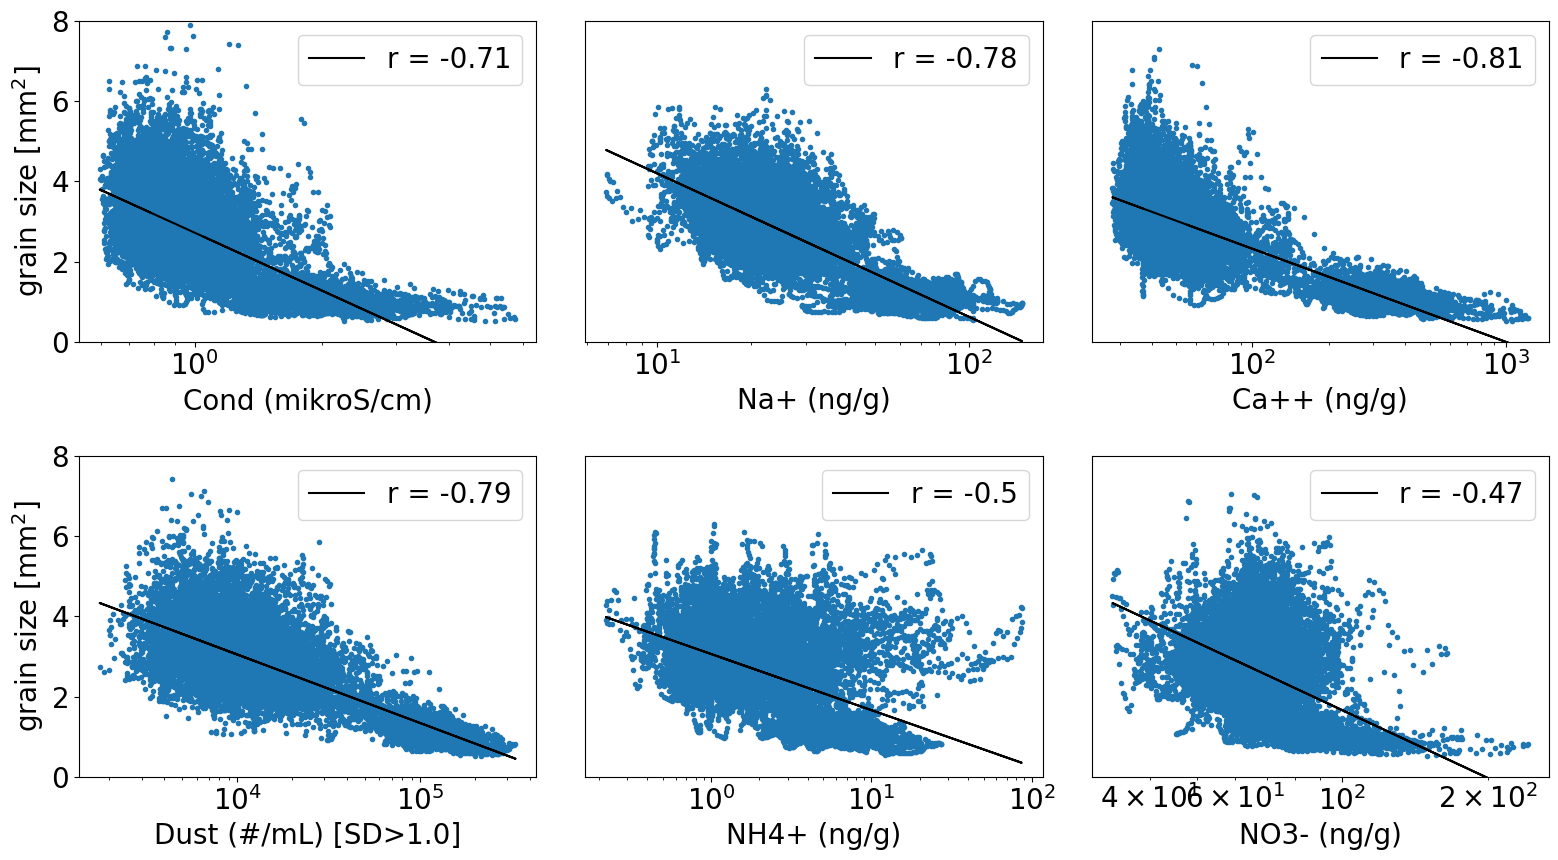

In [11]:
# Make correlations 
fig, ax = plt.subplots(2,3,figsize=(16, 9))
keys_list = list(resolution_mm.keys())
for i in range(2):    
    for j in range(3):
        key = keys_list[j+i*3]
        corr = linregress(np.log(CFA_df[resolution_mm[key]][key]),df_sizes[resolution_mm[key]]["grain_size[px]"]/1000000)
        ax[i,j].semilogx(CFA_df[resolution_mm[key]][key],df_sizes[resolution_mm[key]]["grain_size[px]"]/1000000,".")
        ax[i,j].semilogx(CFA_df[resolution_mm[key]][key],corr.intercept+corr.slope*np.log(CFA_df[resolution_mm[key]][key]),"-",color="black",label="r = {}".format(round(corr.rvalue,2)))
        ax[i,j].set_ylim((0,8))
        #Show stadials correlation
        #stadial_CFA = CFA_df[resolution_mm[key]][CFA_df[resolution_mm[key]]["Depth top (m)"]>(3655-1)*0.55]
        #stadial_CFA = stadial_CFA[stadial_CFA["Depth top (m)"]<=3663*0.55]
        #stadial_xLASM = df_sizes[resolution_mm[key]][df_sizes[resolution_mm[key]]["depth[m]"]>(3655-1)*0.55]
        #stadial_xLASM = stadial_xLASM[stadial_xLASM["depth[m]"]<=3663*0.55]
        #ax[i,j].semilogx(stadial_CFA[key],stadial_xLASM["grain_size[px]"],".",color="tab:red")
        if j == 0:
            ax[i,j].set_ylabel(r"grain size [mm$^2$]")
        else:
            ax[i,j].set_yticks([])
        ax[i,j].set_xlabel(key)
        #ax[i,j].set_title("Correlation grain size and {}".format(key[:4]))
        ax[i,j].legend()
fig.tight_layout()
fig.savefig("Plots/21_CFA_xLASM_corr_1mm.png",dpi=100)
fig.show()